In [18]:
import pandas as pd
mentor_df = pd.read_excel("../shared_data_read_only/Data/Article1/Hackaton_Benevoles_JPMORGAN.xlsx")
mentee_df = pd.read_excel("../shared_data_read_only/Data/Article1/Hackaton_Jeunes_JPMORGAN.xlsx")
binome_df = pd.read_excel("../shared_data_read_only/Data/Article1/Hackaton_Binomes_JPMORGAN.xlsx")

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
import time
import warnings

In [20]:
# Check for duplicates in binome dataset
print(f"Original binome records: {len(binome_df)}")
print(f"Exact duplicates: {binome_df.duplicated().sum()}")

# Remove duplicates
binome_clean = binome_df.drop_duplicates()
binome_clean = binome_clean.drop_duplicates(
    subset=['mentor_id', 'mentee_id', 'binome_date_proposition'],
    keep='first'
)
print(f"After cleaning: {len(binome_clean)}")

# Deduplicate mentee dataset
mentee_df_clean = mentee_df.drop_duplicates(subset=['mentee_id'], keep='first')
print(f"Mentee records: {len(mentee_df)} -> {len(mentee_df_clean)}")

# Filter to shared IDs only
valid_mentor_ids = set(mentor_df['mentor_id'])
valid_mentee_ids = set(mentee_df_clean['mentee_id'])

binome_shared = binome_clean[
    binome_clean['mentor_id'].isin(valid_mentor_ids) & 
    binome_clean['mentee_id'].isin(valid_mentee_ids)
].copy()

print(f"After filtering to shared IDs: {len(binome_shared)}")

# Select and prepare binome columns
binome_selected = binome_shared[['binome_id', 'binome_statut', 'binome_score', 
                                   'mentor_id', 'mentee_id']].copy()

# Convert binome_score to numeric
binome_selected['binome_score'] = pd.to_numeric(binome_selected['binome_score'], errors='coerce')
print(f"\nBinome score - Range: [{binome_selected['binome_score'].min():.0f}, "
      f"{binome_selected['binome_score'].max():.0f}], "
      f"Mean: {binome_selected['binome_score'].mean():.2f}")

Original binome records: 44468
Exact duplicates: 1909
After cleaning: 42552
Mentee records: 51914 -> 45307
After filtering to shared IDs: 14667

Binome score - Range: [0, 12], Mean: 3.70


In [21]:
# Merge datasets
final_df = binome_selected.merge(
    mentor_df[['mentor_id', 'workfield']],
    on='mentor_id',
    how='inner'
)

final_df = final_df.merge(
    mentee_df_clean[[
        'mentee_id', 'field_of_study', 'study_level', 'degree',
        'needs', 'average_grade', 'program', 'engagement_score',
        'desired_exchange_frequency'
    ]],
    on='mentee_id',
    how='inner'
)

print(f"\nAfter merging: {len(final_df)} records")
print(f"Unique mentors: {final_df['mentor_id'].nunique()}")
print(f"Unique mentees: {final_df['mentee_id'].nunique()}")


After merging: 14667 records
Unique mentors: 6435
Unique mentees: 13058


In [42]:
# Filter to final outcomes only
print(f"\nOriginal status distribution:")
print(final_df['binome_statut'].value_counts())

df_ml = final_df[final_df['binome_statut'].isin(['COMPLETED', 'REJECTED', 'CANCELLED'])].copy()
print(f"\nFiltered to final outcomes: {len(df_ml)} records")

# Create binary target: 1 = COMPLETED, 0 = REJECTED/CANCELLED
df_ml['target'] = (df_ml['binome_statut'] == 'COMPLETED').astype(int)

success_count = (df_ml['target'] == 1).sum()
failure_count = (df_ml['target'] == 0).sum()

print(f"\nTarget distribution:")
print(f"  Success (1): {success_count} ({success_count/len(df_ml)*100:.1f}%)")
print(f"  Failure (0): {failure_count} ({failure_count/len(df_ml)*100:.1f}%)")
print(f"  Imbalance ratio: {failure_count/success_count:.2f}:1")

# Verify mapping
completed = (df_ml['binome_statut'] == 'COMPLETED').sum()
rejected = (df_ml['binome_statut'] == 'REJECTED').sum()
cancelled = (df_ml['binome_statut'] == 'CANCELLED').sum()

assert completed == success_count, "COMPLETED count mismatch"
assert (rejected + cancelled) == failure_count, "REJECTED+CANCELLED count mismatch"
print("\nTarget mapping verified")


Original status distribution:
binome_statut
REJECTED     6826
CANCELLED    3460
COMPLETED    3227
ACTIVE        823
PENDING       277
INACTIVE       51
AMBIGUOUS       3
Name: count, dtype: int64

Filtered to final outcomes: 13513 records

Target distribution:
  Success (1): 3227 (23.9%)
  Failure (0): 10286 (76.1%)
  Imbalance ratio: 3.19:1

Target mapping verified


In [44]:
# Select final columns for ML
ml_columns = [
    'binome_id',
    'mentor_id',
    'workfield',
    'mentee_id',
    'field_of_study',
    'study_level',
    'degree',
    'needs',
    'average_grade',
    'program',
    'engagement_score',
    'desired_exchange_frequency',
    'binome_score',
    'target',
    'binome_statut'  # Keep for reference
]

df_ml_final = df_ml[ml_columns].copy()

# Check for missing values
missing = df_ml_final.isnull().sum()
if missing.sum() > 0:
    print("\nMissing values:")
    for col, count in missing[missing > 0].items():
        print(f"  {col}: {count} ({count/len(df_ml_final)*100:.1f}%)")
else:
    print("\nNo missing values")

# Save final dataset
df_ml_final.to_csv('ml_ready_dataset.csv', index=False)

feature_cols = [col for col in ml_columns 
                if col not in ['binome_id', 'mentor_id', 'mentee_id', 'target', 'binome_statut']]

print(f"\nSaved: ml_ready_dataset.csv")
print(f"  Total records: {len(df_ml_final)}")
print(f"  Features: {len(feature_cols)}")
print(f"  Target: binary (0=failure, 1=success)")

print(f"\nFeatures included:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")


Missing values:
  workfield: 1380 (10.2%)
  binome_score: 53 (0.4%)

Saved: ml_ready_dataset.csv
  Total records: 13513
  Features: 10
  Target: binary (0=failure, 1=success)

Features included:
   1. workfield
   2. field_of_study
   3. study_level
   4. degree
   5. needs
   6. average_grade
   7. program
   8. engagement_score
   9. desired_exchange_frequency
  10. binome_score


In [45]:
df_ml_final.head()

,binome_id,mentor_id,workfield,mentee_id,field_of_study,study_level,degree,needs,average_grade,program,engagement_score,desired_exchange_frequency,binome_score,target,binome_statut
0,157729,63390,Human Resources,190853,"Commerce, Management, Economics, Management",Bac+1,Licence,[pro],Not specified (or Not provided),PP,3,More than once per week,8.0,0,REJECTED
1,157825,63427,Computer science,190906,"IT, IS, Data, Web, Tech",Bac+2,BTS,[pro],Not specified (or Not provided),PNP,0,Once every two weeks (or Bi-weekly),8.0,0,REJECTED
2,157838,63393,Banking-Finance,190828,"Banking, Insurance and Finance",Bac+3,Licence,[pro],Not specified (or Not provided),PNP,4,More than once per week,10.0,0,REJECTED
3,157856,63387,"Accounting, management",191078,"Accounting, Finance",Bac+1,BTS,[pro],Not specified (or Not provided),PNP,1,More than once per week,5.0,0,REJECTED
5,157942,63447,Computer science,190937,"IT, IS, Data, Web, Tech",Bac+1,Autre,[pro],Not specified (or Not provided),PNP,3,Once every two weeks (or Bi-weekly),4.0,1,COMPLETED


In [46]:
# Load data
df = pd.read_csv('ml_ready_dataset.csv')
print(f"Loaded: {len(df)} records, {len(df.columns)} columns\n")

# Feature engineering
df_processed = df.copy()

# Field similarity between mentor and mentee
def check_field_similarity(row):
    workfield = str(row['workfield']).lower()
    field_of_study = str(row['field_of_study']).lower()
    
    if pd.isna(row['workfield']) or pd.isna(row['field_of_study']):
        return 0
    if workfield == field_of_study:
        return 2  # Exact match
    
    # Check for related fields
    related_fields = {
        'computer science': ['it, is, data, web, tech'],
        'banking-finance': ['banking, insurance and finance', 'accounting, finance'],
        'accounting': ['accounting, finance', 'commerce, management'],
        'human resources': ['commerce, management'],
    }
    
    for key, values in related_fields.items():
        if key in workfield:
            for value in values:
                if value in field_of_study:
                    return 1  # Related
    return 0  # Unrelated

df_processed['field_similarity'] = df_processed.apply(check_field_similarity, axis=1)

# Parse mentee needs
df_processed['needs_pro'] = df_processed['needs'].str.contains('pro', case=False, na=False).astype(int)
df_processed['needs_study'] = df_processed['needs'].str.contains('study', case=False, na=False).astype(int)

print("Feature engineering complete")

# Prepare features and target
feature_cols = [
    'workfield', 'field_of_study', 'study_level', 'degree',
    'program', 'average_grade', 'desired_exchange_frequency',
    'engagement_score', 'field_similarity',
    'needs_pro', 'needs_study', 'binome_score'
]

X = df_processed[feature_cols].copy()
y = df_processed['target'].copy()

print(f"Features: {len(feature_cols)}, Samples: {len(X)}")

Loaded: 13513 records, 15 columns

Feature engineering complete
Features: 12, Samples: 13513


In [47]:
# Handle missing values
categorical_cols = ['workfield', 'field_of_study', 'study_level', 'degree',
                   'program', 'average_grade', 'desired_exchange_frequency']
numerical_cols = ['engagement_score', 'field_similarity',
                 'needs_pro', 'needs_study', 'binome_score']

for col in categorical_cols:
    X[col] = X[col].fillna('Unknown')

for col in numerical_cols:
    X[col] = X[col].fillna(X[col].median())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}\n")

# Encode categorical features
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
    X_test_encoded[col] = X_test[col].astype(str).map(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
    label_encoders[col] = le

# Scale features for distance-based models
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_encoded),
    columns=X_train_encoded.columns,
    index=X_train_encoded.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_encoded),
    columns=X_test_encoded.columns,
    index=X_test_encoded.index
)

Train: 10810, Test: 2703



In [30]:
# Define models
models = {
    'Logistic Regression': {
        'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        'use_scaled': True
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(max_depth=10, min_samples_split=20, min_samples_leaf=10, 
                                        class_weight='balanced', random_state=42),
        'use_scaled': False
    },
    'Random Forest': {
        'model': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=20,
                                        min_samples_leaf=10, class_weight='balanced', 
                                        random_state=42, n_jobs=-1),
        'use_scaled': False
    },
    'Extra Trees': {
        'model': ExtraTreesClassifier(n_estimators=100, max_depth=10, min_samples_split=20,
                                      min_samples_leaf=10, class_weight='balanced', 
                                      random_state=42, n_jobs=-1),
        'use_scaled': False
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=5,
                                            min_samples_split=20, min_samples_leaf=10, 
                                            subsample=0.8, random_state=42),
        'use_scaled': False
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'use_scaled': True
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(n_neighbors=15, weights='distance', n_jobs=-1),
        'use_scaled': True
    }
}

results = {}
confusion_matrices = {}

In [31]:
# Train and evaluate each model
for name, config in models.items():
    print(f"\n{name}")
    print("-" * 70)
    
    model = config['model']
    use_scaled = config['use_scaled']
    
    X_tr = X_train_scaled if use_scaled else X_train_encoded
    X_te = X_test_scaled if use_scaled else X_test_encoded
    
    # Train
    start_time = time.time()
    model.fit(X_tr, y_train)
    train_time = time.time() - start_time
    
    # Predict
    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)
    
    # Store results
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    results[name] = {
        'model': model,
        'auc': auc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'train_time': train_time
    }
    confusion_matrices[name] = cm
    
    # Print results
    print(f"Training time: {train_time:.2f}s")
    if auc:
        print(f"AUC: {auc:.4f}")
    print(f"F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Failure  Success")
    print(f"Actual Failure   {tn:4d}    {fp:4d}")
    print(f"       Success   {fn:4d}    {tp:4d}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Failure', 'Success']))


Logistic Regression
----------------------------------------------------------------------
Training time: 0.04s
AUC: 0.6065
F1-Score: 0.3874, Precision: 0.3037, Recall: 0.5349

Confusion Matrix:
                Predicted
              Failure  Success
Actual Failure   1267     791
       Success    300     345

Classification Report:
              precision    recall  f1-score   support

     Failure       0.81      0.62      0.70      2058
     Success       0.30      0.53      0.39       645

    accuracy                           0.60      2703
   macro avg       0.56      0.58      0.54      2703
weighted avg       0.69      0.60      0.62      2703


Decision Tree
----------------------------------------------------------------------
Training time: 0.05s
AUC: 0.5859
F1-Score: 0.3943, Precision: 0.2926, Recall: 0.6047

Confusion Matrix:
                Predicted
              Failure  Success
Actual Failure   1115     943
       Success    255     390

Classification Report:
     

In [34]:
# CatBoost
print(f"CatBoost")

catboost = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    cat_features=categorical_cols,
    auto_class_weights='Balanced',
    random_seed=42,
    verbose=0
)

start_time = time.time()
catboost.fit(X_train, y_train, eval_set=(X_test, y_test), 
             early_stopping_rounds=50, verbose=False)
train_time = time.time() - start_time

y_pred = catboost.predict(X_test)
y_pred_proba = catboost.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#CatBoost
results['CatBoost'] = {
    'model': catboost,
    'auc': auc,
    'f1': f1,
    'precision': precision,
    'recall': recall,
    'train_time': train_time
}
confusion_matrices['CatBoost'] = cm

print(f"Training time: {train_time:.2f}s")
print(f"AUC: {auc:.4f}")
print(f"F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

print("\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Failure  Success")
print(f"Actual Failure   {tn:4d}    {fp:4d}")
print(f"       Success   {fn:4d}    {tp:4d}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Failure', 'Success']))

CatBoost
Training time: 2.18s
AUC: 0.6255
F1-Score: 0.4052, Precision: 0.3043, Recall: 0.6062

Confusion Matrix:
                Predicted
              Failure  Success
Actual Failure   1164     894
       Success    254     391

Classification Report:
              precision    recall  f1-score   support

     Failure       0.82      0.57      0.67      2058
     Success       0.30      0.61      0.41       645

    accuracy                           0.58      2703
   macro avg       0.56      0.59      0.54      2703
weighted avg       0.70      0.58      0.61      2703



In [35]:
# XGBoost
print(f"XGBoost")
print("-" * 70)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc'
)

start_time = time.time()
xgb_model.fit(X_train_encoded, y_train, 
              eval_set=[(X_test_encoded, y_test)], verbose=False)
train_time = time.time() - start_time

y_pred = xgb_model.predict(X_test_encoded)
y_pred_proba = xgb_model.predict_proba(X_test_encoded)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

results['XGBoost'] = {
    'model': xgb_model,
    'auc': auc,
    'f1': f1,
    'precision': precision,
    'recall': recall,
    'train_time': train_time
}
confusion_matrices['XGBoost'] = cm

print(f"Training time: {train_time:.2f}s")
print(f"AUC: {auc:.4f}")
print(f"F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

print("\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Failure  Success")
print(f"Actual Failure   {tn:4d}    {fp:4d}")
print(f"       Success   {fn:4d}    {tp:4d}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Failure', 'Success']))

XGBoost
----------------------------------------------------------------------
Training time: 0.28s
AUC: 0.6101
F1-Score: 0.3882, Precision: 0.3067, Recall: 0.5287

Confusion Matrix:
                Predicted
              Failure  Success
Actual Failure   1287     771
       Success    304     341

Classification Report:
              precision    recall  f1-score   support

     Failure       0.81      0.63      0.71      2058
     Success       0.31      0.53      0.39       645

    accuracy                           0.60      2703
   macro avg       0.56      0.58      0.55      2703
weighted avg       0.69      0.60      0.63      2703



In [36]:
# LightGBM
print(f"LightGBM")

lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

start_time = time.time()
lgb_model.fit(X_train_encoded, y_train, 
              eval_set=[(X_test_encoded, y_test)], eval_metric='auc')
train_time = time.time() - start_time

y_pred = lgb_model.predict(X_test_encoded)
y_pred_proba = lgb_model.predict_proba(X_test_encoded)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

results['LightGBM'] = {
    'model': lgb_model,
    'auc': auc,
    'f1': f1,
    'precision': precision,
    'recall': recall,
    'train_time': train_time
}
confusion_matrices['LightGBM'] = cm

print(f"Training time: {train_time:.2f}s")
print(f"AUC: {auc:.4f}")
print(f"F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

print("\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Failure  Success")
print(f"Actual Failure   {tn:4d}    {fp:4d}")
print(f"       Success   {fn:4d}    {tp:4d}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Failure', 'Success']))

LightGBM
Training time: 0.36s
AUC: 0.6057
F1-Score: 0.3792, Precision: 0.2966, Recall: 0.5256

Confusion Matrix:
                Predicted
              Failure  Success
Actual Failure   1254     804
       Success    306     339

Classification Report:
              precision    recall  f1-score   support

     Failure       0.80      0.61      0.69      2058
     Success       0.30      0.53      0.38       645

    accuracy                           0.59      2703
   macro avg       0.55      0.57      0.54      2703
weighted avg       0.68      0.59      0.62      2703




MODEL COMPARISON SUMMARY

              Model      AUC       F1  Precision   Recall  Time (s)
        Extra Trees 0.631212 0.417666   0.322119 0.593798  0.196602
           CatBoost 0.625497 0.405181   0.304280 0.606202  2.184705
      Random Forest 0.618062 0.397252   0.314882 0.537984  0.245388
  Gradient Boosting 0.614871 0.079659   0.482759 0.043411  1.259884
            XGBoost 0.610133 0.388162   0.306655 0.528682  0.275152
        Naive Bayes 0.608652 0.186916   0.379147 0.124031  0.004329
Logistic Regression 0.606529 0.387423   0.303697 0.534884  0.041536
           LightGBM 0.605715 0.379195   0.296588 0.525581  0.360258
      Decision Tree 0.585925 0.394338   0.292573 0.604651  0.045480
K-Nearest Neighbors 0.565679 0.131313   0.353741 0.080620  0.015859

Best Model: Extra Trees (AUC: 0.6312)

Saved: all_confusion_matrices.png
Saved: best_model_confusion_matrix.png
Saved: best_model.pkl


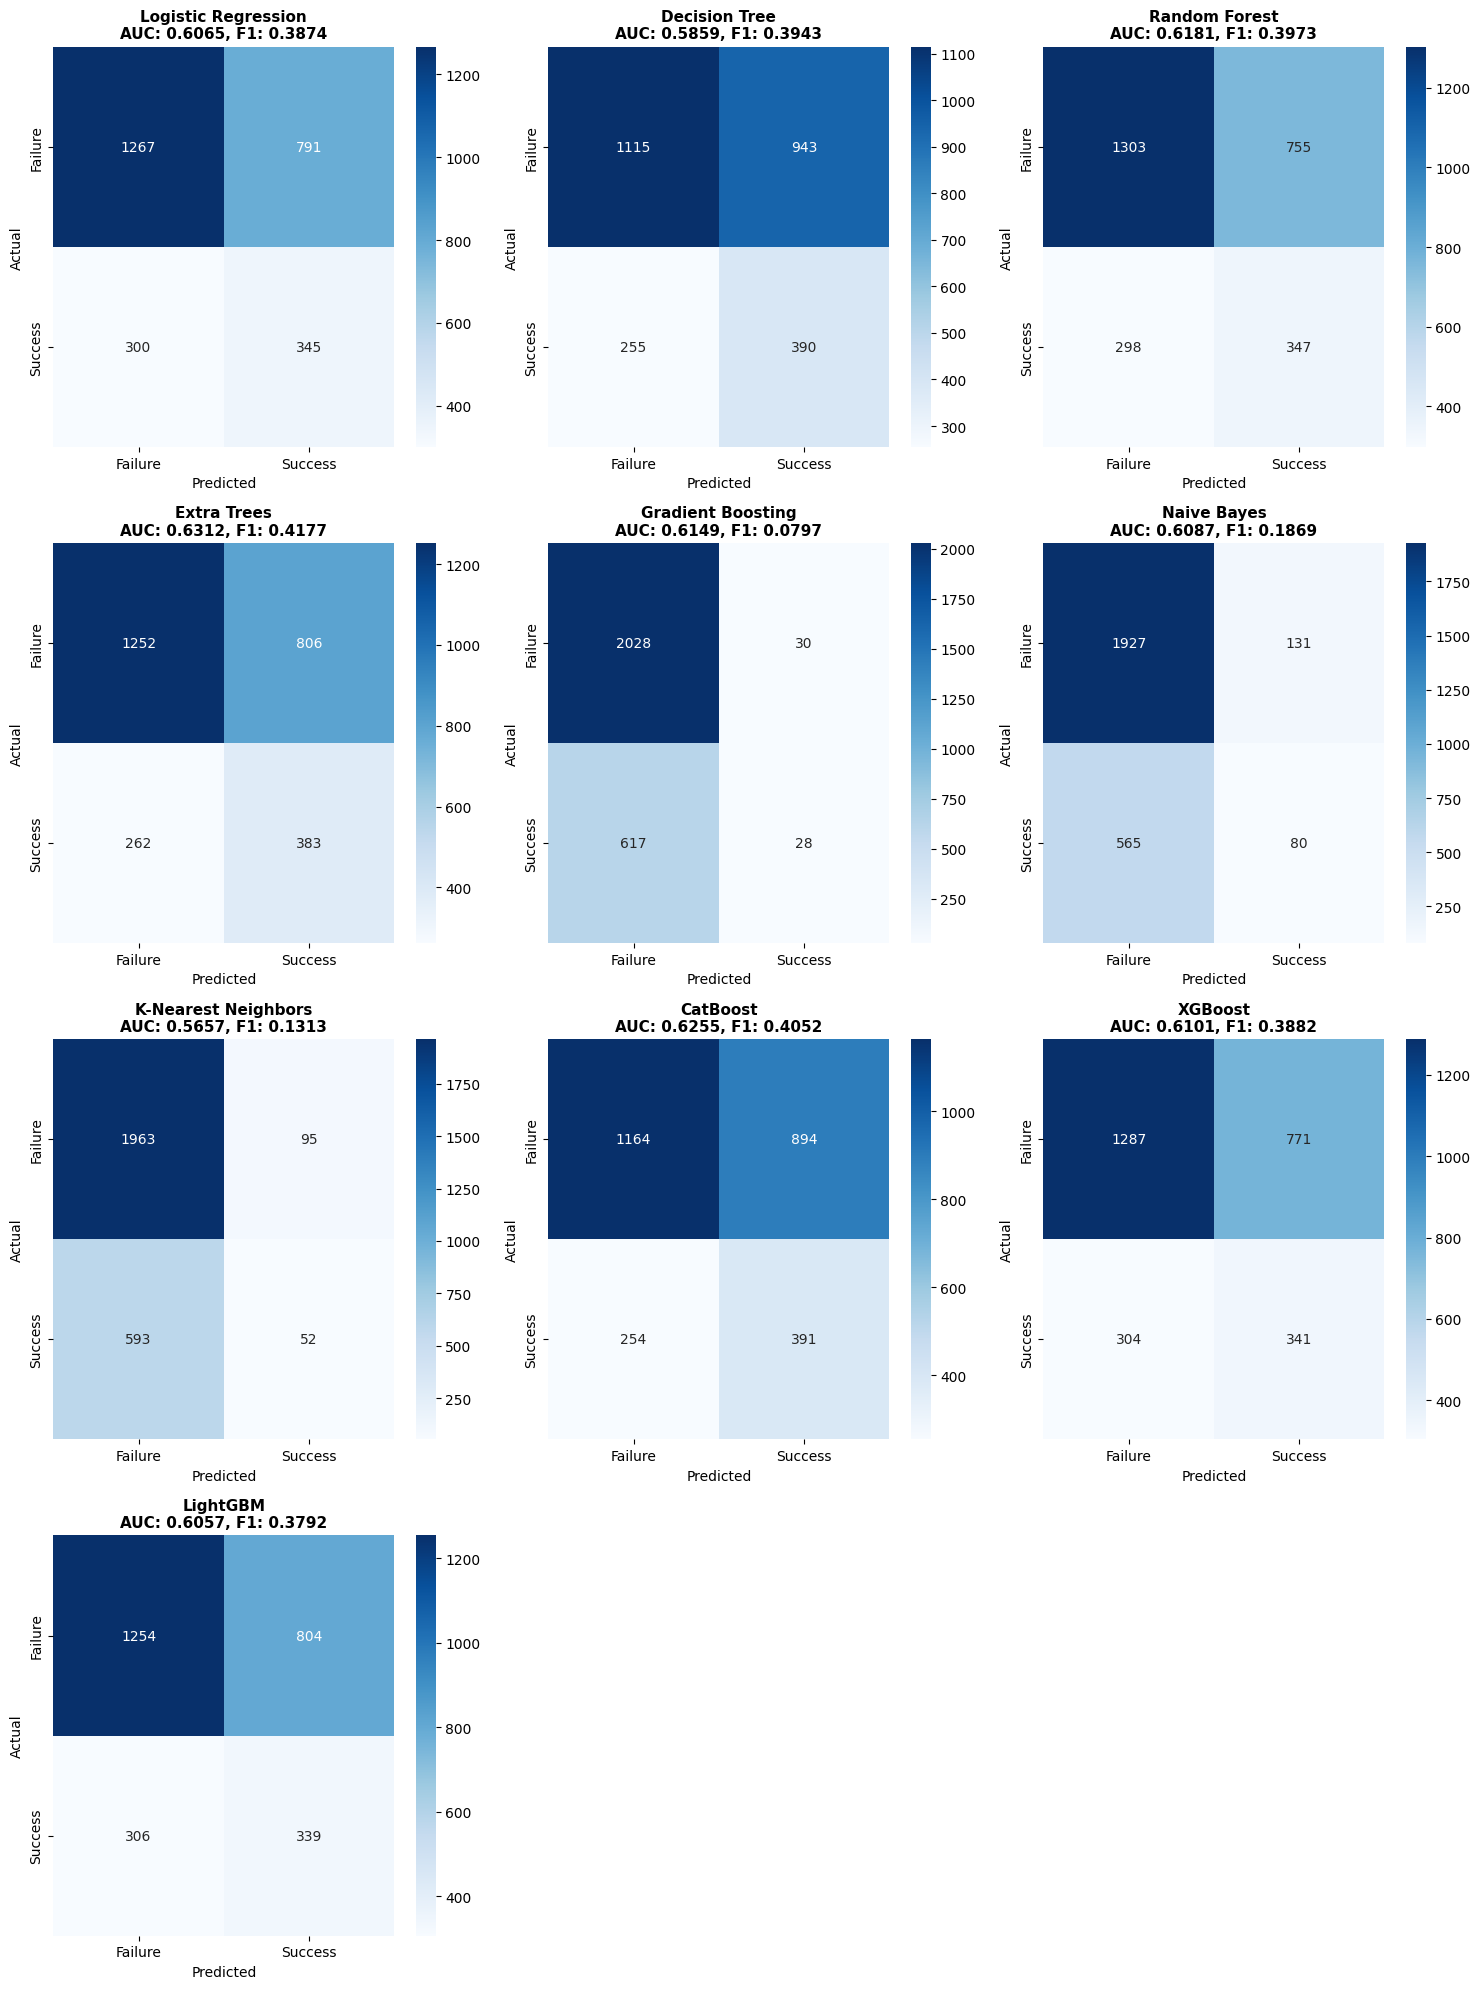

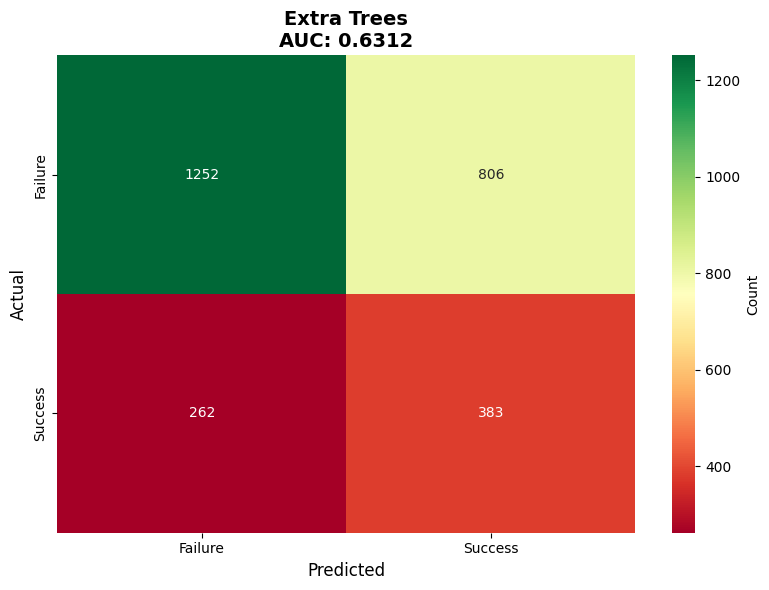

In [37]:
# Summary comparison table
print("\n" + "=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'AUC': [results[m]['auc'] if results[m]['auc'] else 0 for m in results.keys()],
    'F1': [results[m]['f1'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'Time (s)': [results[m]['train_time'] for m in results.keys()]
}).sort_values('AUC', ascending=False)

print("\n" + comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['Model']
best_auc = comparison_df.iloc[0]['AUC']
print(f"\nBest Model: {best_model_name} (AUC: {best_auc:.4f})")

# Visualize all confusion matrices
n_models = len(confusion_matrices)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, (name, cm) in enumerate(confusion_matrices.items()):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Failure', 'Success'],
                yticklabels=['Failure', 'Success'])
    
    auc_score = results[name]['auc']
    f1_score = results[name]['f1']
    title = f"{name}\nAUC: {auc_score:.4f}, F1: {f1_score:.4f}" if auc_score else f"{name}\nF1: {f1_score:.4f}"
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('all_confusion_matrices.png', dpi=300, bbox_inches='tight')
print(f"\nSaved: all_confusion_matrices.png")

# Best model detailed confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
best_cm = confusion_matrices[best_model_name]
sns.heatmap(best_cm, annot=True, fmt='d', cmap='RdYlGn', ax=ax,
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'],
            cbar_kws={'label': 'Count'})

ax.set_title(f'{best_model_name}\nAUC: {best_auc:.4f}', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12)
ax.set_xlabel('Predicted', fontsize=12)

plt.tight_layout()
plt.savefig('best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f"Saved: best_model_confusion_matrix.png")

# Save best model
best_model = results[best_model_name]['model']
if best_model_name == 'CatBoost':
    best_model.save_model('best_model.cbm')
    print(f"Saved: best_model.cbm")
else:
    import joblib
    joblib.dump(best_model, 'best_model.pkl')
    print(f"Saved: best_model.pkl")

plt.show()

In [38]:
rf_model = results['Random Forest']['model']

print(f"\nRandom Forest: {rf_model.n_estimators} trees, max_depth={rf_model.max_depth}")
print(f"Test AUC: {results['Random Forest']['auc']:.4f}\n")

# Extract feature importances
feature_names = X_train_encoded.columns.tolist()
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Importance_%': importances * 100
}).sort_values('Importance', ascending=False)

print("Feature Importance Scores:")
print(feature_importance_df.to_string(index=False))

# Analyze top features
top5 = feature_importance_df.head(5)
top5_importance = top5['Importance_%'].sum()

print(f"\nTop 5 features account for {top5_importance:.1f}% of total importance")

# Calculate cumulative importance
feature_importance_df['Cumulative_%'] = feature_importance_df['Importance_%'].cumsum()
features_80 = (feature_importance_df['Cumulative_%'] <= 80).sum()
features_90 = (feature_importance_df['Cumulative_%'] <= 90).sum()

print(f"Top {features_80} features = 80% importance")
print(f"Top {features_90} features = 90% importance\n")

# Feature interpretations
interpretations = {
    'engagement_score': 'Mentee motivation/commitment',
    'field_of_study': 'Mentee field of study',
    'study_level': 'Academic level',
    'degree': 'Degree program type',
    'workfield': 'Mentor professional field',
    'binome_score': 'Compatibility score',
    'program': 'Mentorship program type',
    'average_grade': 'Academic performance',
    'field_similarity': 'Field match quality',
    'desired_exchange_frequency': 'Meeting frequency preference'
}


Random Forest: 100 trees, max_depth=10
Test AUC: 0.6181

Feature Importance Scores:
                   Feature  Importance  Importance_%
          engagement_score    0.241978     24.197791
                 workfield    0.156348     15.634765
            field_of_study    0.138675     13.867549
              binome_score    0.106361     10.636130
                    degree    0.078972      7.897237
               study_level    0.078050      7.805016
             average_grade    0.077132      7.713179
                   program    0.057278      5.727809
                 needs_pro    0.021177      2.117711
               needs_study    0.019762      1.976204
          field_similarity    0.013844      1.384377
desired_exchange_frequency    0.010422      1.042232

Top 5 features account for 72.2% of total importance
Top 5 features = 80% importance
Top 7 features = 90% importance



Top 5 Features:
1. engagement_score: 24.2% - Mentee motivation/commitment
2. workfield: 15.6% - Mentor professional field (categorical)
3. field_of_study: 13.9% - Mentee field of study (categorical)
4. binome_score: 10.6% - Compatibility score
5. degree: 7.9% - Degree program type (categorical)


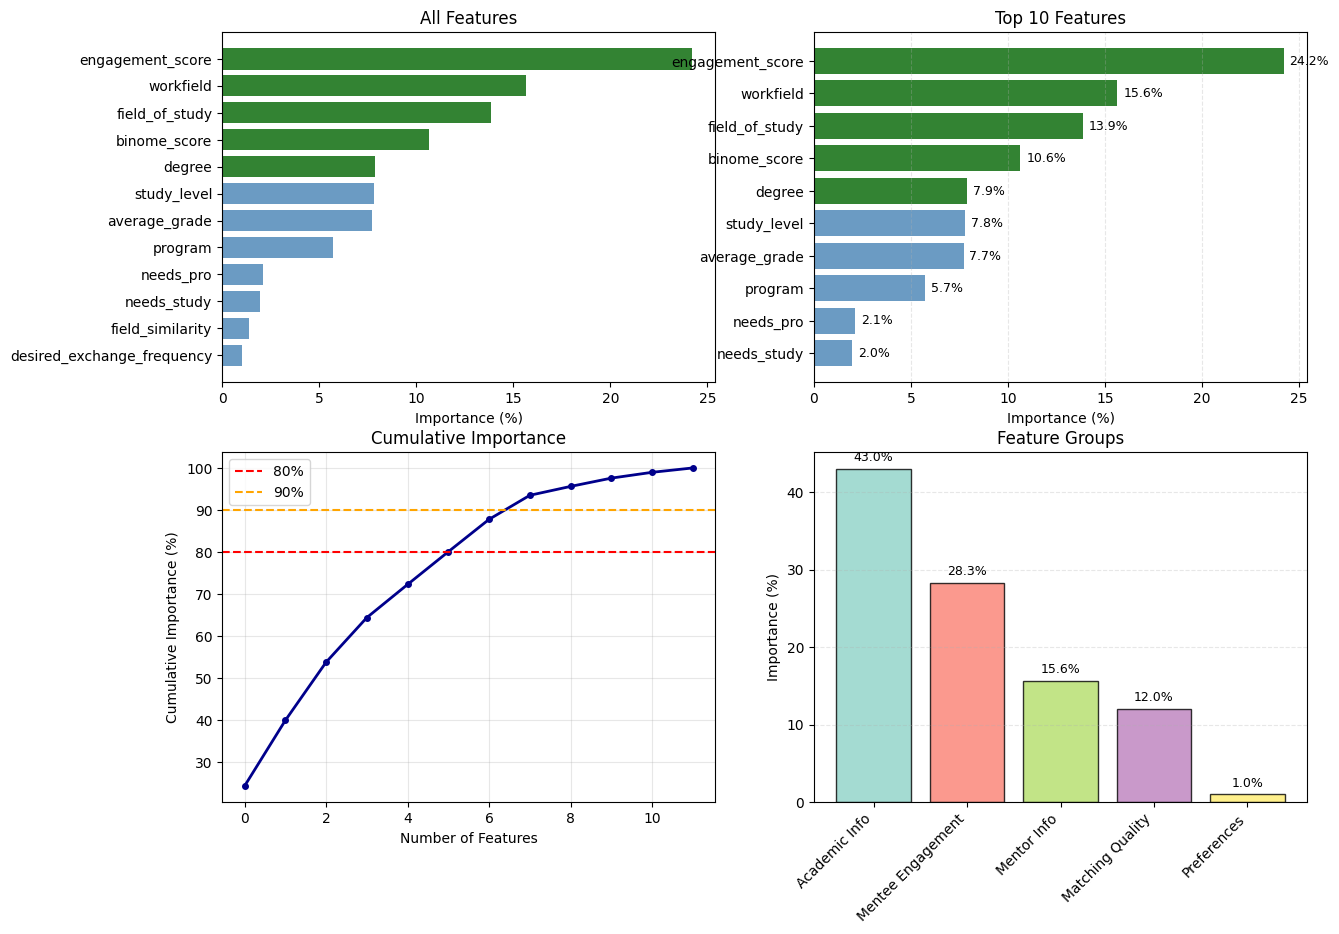

In [39]:
print("Top 5 Features:")
for i, (idx, row) in enumerate(top5.iterrows(), 1):
    interpretation = interpretations.get(row['Feature'], 'N/A')
    categorical = " (categorical)" if row['Feature'] in categorical_cols else ""
    print(f"{i}. {row['Feature']}: {row['Importance_%']:.1f}% - {interpretation}{categorical}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# All features
ax = axes[0, 0]
colors = ['darkgreen' if i < 5 else 'steelblue' for i in range(len(feature_importance_df))]
ax.barh(range(len(feature_importance_df)), feature_importance_df['Importance_%'], 
        color=colors, alpha=0.8)
ax.set_yticks(range(len(feature_importance_df)))
ax.set_yticklabels(feature_importance_df['Feature'])
ax.set_xlabel('Importance (%)')
ax.set_title('All Features')
ax.invert_yaxis()

# Top 10 features
ax = axes[0, 1]
top10 = feature_importance_df.head(10)
colors_top10 = ['darkgreen'] * 5 + ['steelblue'] * 5
bars = ax.barh(range(len(top10)), top10['Importance_%'], color=colors_top10, alpha=0.8)
ax.set_yticks(range(len(top10)))
ax.set_yticklabels(top10['Feature'])
ax.set_xlabel('Importance (%)')
ax.set_title('Top 10 Features')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')
for i, (idx, row) in enumerate(top10.iterrows()):
    ax.text(row['Importance_%'] + 0.3, i, f"{row['Importance_%']:.1f}%", va='center', fontsize=9)

# Cumulative importance
ax = axes[1, 0]
ax.plot(range(len(feature_importance_df)), feature_importance_df['Cumulative_%'], 
        marker='o', linewidth=2, markersize=4, color='darkblue')
ax.axhline(y=80, color='red', linestyle='--', label='80%')
ax.axhline(y=90, color='orange', linestyle='--', label='90%')
ax.set_xlabel('Number of Features')
ax.set_ylabel('Cumulative Importance (%)')
ax.set_title('Cumulative Importance')
ax.grid(alpha=0.3)
ax.legend()

# Feature groups
feature_groups = {
    'Mentee Engagement': ['engagement_score', 'needs_pro', 'needs_study'],
    'Academic Info': ['field_of_study', 'study_level', 'degree', 'average_grade', 'program'],
    'Mentor Info': ['workfield'],
    'Matching Quality': ['binome_score', 'field_similarity'],
    'Preferences': ['desired_exchange_frequency']
}

group_importance = {}
for group_name, features in feature_groups.items():
    group_total = feature_importance_df[feature_importance_df['Feature'].isin(features)]['Importance_%'].sum()
    group_importance[group_name] = group_total

group_df = pd.DataFrame(list(group_importance.items()), 
                        columns=['Group', 'Importance_%']).sort_values('Importance_%', ascending=False)

ax = axes[1, 1]
colors = plt.cm.Set3(np.linspace(0, 1, len(group_df)))
bars = ax.bar(range(len(group_df)), group_df['Importance_%'], 
              color=colors, alpha=0.8, edgecolor='black')
ax.set_xticks(range(len(group_df)))
ax.set_xticklabels(group_df['Group'], rotation=45, ha='right')
ax.set_ylabel('Importance (%)')
ax.set_title('Feature Groups')
ax.grid(axis='y', alpha=0.3, linestyle='--')
for i, (idx, row) in enumerate(group_df.iterrows()):
    ax.text(i, row['Importance_%'] + 1, f"{row['Importance_%']:.1f}%", ha='center', fontsize=9)

In [40]:
plt.tight_layout()
plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
print("\nSaved: feature_importance_analysis.png")

# Export results
feature_importance_df.to_csv('feature_importance.csv', index=False)
group_df.to_csv('feature_groups.csv', index=False)
print("Saved: feature_importance.csv, feature_groups.csv")

# Key insights
print(f"\nKey Insights:")
print(f"- Most important: {top5.iloc[0]['Feature']} ({top5.iloc[0]['Importance_%']:.1f}%)")
print(f"- Most important group: {group_df.iloc[0]['Group']} ({group_df.iloc[0]['Importance_%']:.1f}%)")
print(f"- Focus on top {features_80} features for 80% of model decisions")


Saved: feature_importance_analysis.png
Saved: feature_importance.csv, feature_groups.csv

Key Insights:
- Most important: engagement_score (24.2%)
- Most important group: Academic Info (43.0%)
- Focus on top 5 features for 80% of model decisions


<Figure size 640x480 with 0 Axes>